In [4]:
import firedrake as fd
from tqdm.auto import tqdm, trange
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt

## Random scalar field

100%|██████████| 2/2 [00:00<00:00, 390.17it/s]

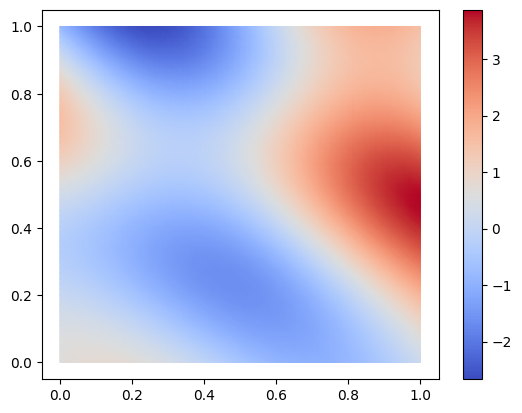

In [5]:
def random_field(V, N: int = 1, m: int = 5, σ: float = 0.6,
                 tqdm: bool = False, seed: int = 2023):
    """Generate N 2D random fields with m modes."""
    rng = default_rng(seed)
    x, y = fd.SpatialCoordinate(V.ufl_domain())
    fields = []
    for _ in trange(N, disable=not tqdm):
        r = 0
        for _ in range(m):
            a, b = rng.standard_normal(2)
            k1, k2 = rng.normal(0, σ, 2)
            θ = 2 * np.pi * (k1 * x + k2 * y)
            r += fd.Constant(a) * fd.cos(θ) + fd.Constant(b) * fd.sin(θ)
        fields.append(fd.interpolate(np.sqrt(1 / m) * r, V))
    return fields

mesh = fd.UnitSquareMesh(32, 32)
V = fd.FunctionSpace(mesh, "CG", 1)
fields = random_field(V, N=2, tqdm=True, seed=20)
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
collection = fd.tripcolor(fields[1], axes=axes, cmap='coolwarm')
fig.colorbar(collection);

## generate random strain tensor field

In [6]:
# Random tensor field function definition
def random_tensor_field(V, N: int = 1, m: int = 5, σ: float = 0.6, tqdm: bool = False, seed: int = 2023):
    """Generate N 2D random tensor fields with m modes."""
    rng = default_rng(seed)
    x, y = fd.SpatialCoordinate(V.mesh())

    fields = []
    for _ in trange(N, disable=not tqdm):
        tensor_components = [[], [], []]
        for i in range(3):  # repeat four times to get a 2x2 tensor
            r = 0
            for _ in range(m):
                a, b = rng.standard_normal(2)
                k1, k2 = rng.normal(0, σ, 2)
                θ = 2 * np.pi * (k1 * x + k2 * y)
                r += fd.Constant(a) * fd.cos(θ) + fd.Constant(b) * fd.sin(θ)
            r_val = np.sqrt(1./m) * r
            tensor_components[i] = r_val
        tensor_field = fd.as_tensor([[tensor_components[0], tensor_components[1]], [tensor_components[1], tensor_components[2]]])
        fields.append(fd.interpolate(tensor_field, V))
    return fields

# Create a mesh and a TensorFunctionSpace
mesh = fd.UnitSquareMesh(32, 32)
V = fd.TensorFunctionSpace(mesh, "CG", 1)

# Generate random tensor fields
tensor_fields = random_tensor_field(V, N=2, tqdm=True, seed=20)

100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


In [7]:
fd.assemble(tensor_fields[0][0,0] * fd.dx)

-0.4118639619787451

In [8]:
fd.assemble(tensor_fields[0][0,1] * fd.dx)

0.19783071221114157

In [9]:
fd.assemble(tensor_fields[0][1,0] * fd.dx)

0.19783071221114157

In [10]:
fd.assemble(tensor_fields[0][1,1] * fd.dx)

0.049625583132772474

In [11]:
tensor_fields

[Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x157039a90>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 9)), 88),
 Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x157039a90>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 9)), 123)]

In [12]:
tensor_fields[0]

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x157039a90>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 9)), 88)

In [13]:
tensor_fields[0].dat.data

array([[[-0.44040667,  0.64099698],
        [ 0.64099698, -0.10357319]],

       [[-0.34249163,  0.62868613],
        [ 0.62868613, -0.45551932]],

       [[-0.25964421,  0.7066767 ],
        [ 0.7066767 , -0.00912176]],

       ...,

       [[ 0.01974311,  1.39752516],
        [ 1.39752516, -2.02376824]],

       [[-0.05273883,  1.6667174 ],
        [ 1.6667174 , -1.9762833 ]],

       [[ 0.0929542 ,  1.5090549 ],
        [ 1.5090549 , -1.97637665]]])

In [14]:
tensor_fields[0].dat.data[1]

array([[-0.34249163,  0.62868613],
       [ 0.62868613, -0.45551932]])

## Three pictures show the three tensor components of strain: exx, exy and eyx, eyy

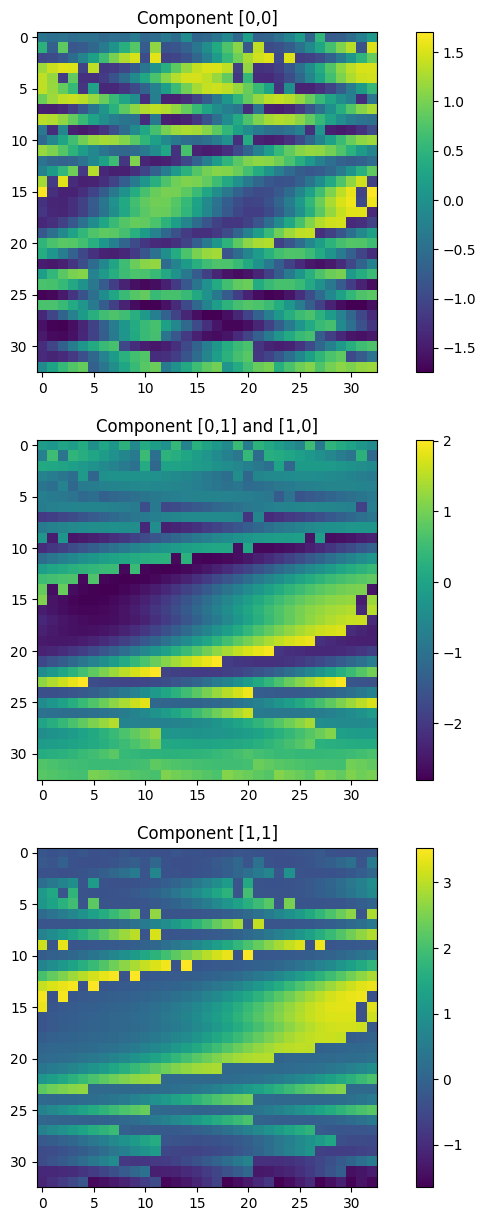

In [15]:
# Extract components
comp_00 = tensor_fields[1].dat.data[:, 0, 0]
comp_01_10 = tensor_fields[1].dat.data[:, 0, 1]  # This is also [1, 0] component
comp_11 = tensor_fields[1].dat.data[:, 1, 1]
# Determine reshaping dimensions
# Plot each component
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
img00 = axes[0].imshow(comp_00.reshape(33, 33))
axes[0].set_title('Component [0,0]')
fig.colorbar(img00, ax=axes[0])

img10 = axes[1].imshow(comp_01_10.reshape(33, 33))
axes[1].set_title('Component [0,1] and [1,0]')
fig.colorbar(img10, ax=axes[1])

img11 = axes[2].imshow(comp_11.reshape(33, 33))
axes[2].set_title('Component [1,1]')
fig.colorbar(img11, ax=axes[2])
plt.show()

## Solve PDE in firedrake using input strain field to calculate stress field

In [16]:
E = 1.
nu = 0.3

def forward(E, nu, strain_tensor):
    ## define displacement 
    V_vector = fd.VectorFunctionSpace(mesh, 'CG', 1)
    V_tensor = fd.TensorFunctionSpace(mesh, 'CG', 1)
    u = fd.TrialFunction(V_vector)
    v = fd.TestFunction(V_vector)
    u_sol = fd.Function(V_vector)
    
    mu = E/(2*(1+nu))
    lmbda = E*nu/((1+nu)*(1-2*nu))

    def epsilon(u):
        return fd.sym(fd.grad(u))
        # return 0.5*(fd.grad(u) + fd.grad(u.T))
    def sigma(u):
        return lmbda*fd.tr(epsilon(u))*fd.Identity(2) + 2*mu*epsilon(u)
    # Body force
    f = fd.Constant((0.0, 0.0))
    
    exx, eyy, exy = strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]
    x,y = fd.SpatialCoordinate(mesh)
    uLx = exx * x + exy * y
    uLy = exy * x
    uRx = exx * x + exy * y
    uRy = exy * x
    
    uBx = exy * y
    uBy = eyy * y + exy * x
    uTx = exy * y
    uTy = eyy * y + exy * x
    
    bcL = fd.DirichletBC(V_vector, [uLx, uLy], 1)
    bcR = fd.DirichletBC(V_vector, [uRx, uRy], 2)
    bcB = fd.DirichletBC(V_vector, [uBx, uBy], 3)
    bcT = fd.DirichletBC(V_vector, [uTx, uTy], 4)
    
    # Define the weak form
    a = fd.inner(sigma(u), epsilon(v)) * fd.dx 
    # +inner(sigma(u_) * n, v) * ds(1) - inner(sigma(u_) * n, v) * ds(2) + inner(sigma(u_) * n, v) * ds(3) - inner(sigma(u_) * n, v) * ds(4) 
    L = fd.inner(f, v) * fd.dx
    
    fd.solve(a == L, u_sol,bcs=[bcL, bcB, bcR, bcT])
    
    return fd.project(sigma(u_sol), V_tensor)


stress_field = forward(E, nu, tensor_fields[0])

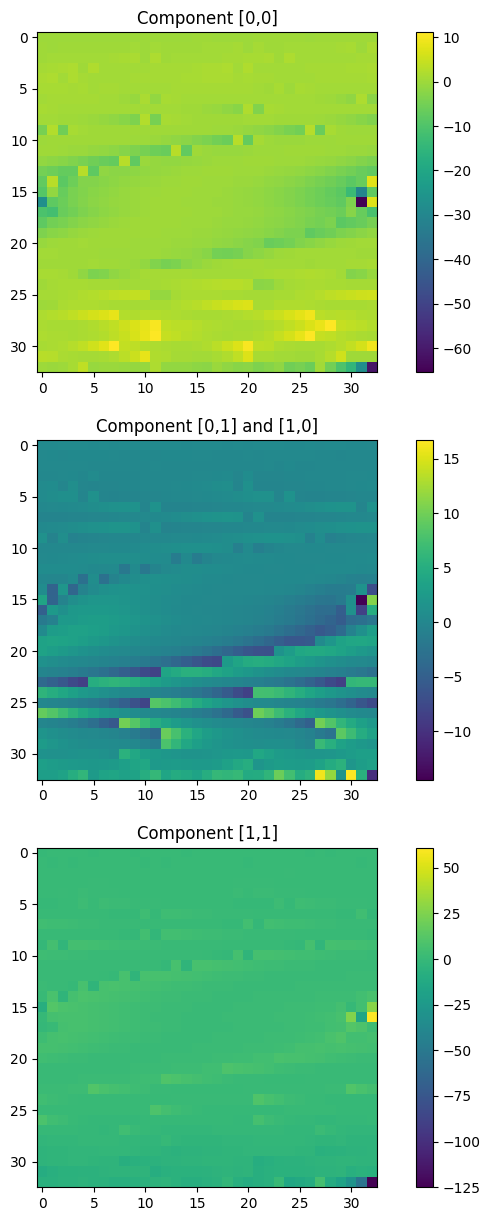

In [18]:
# Extract components
# Determine reshaping dimensions
# Plot each component
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
img00 = axes[0].imshow(stress_field.dat.data[:,0,0].reshape(33, 33))
axes[0].set_title('Component [0,0]')
fig.colorbar(img00, ax=axes[0])

img10 = axes[1].imshow(stress_field.dat.data[:,1,0].reshape(33, 33))
axes[1].set_title('Component [0,1] and [1,0]')
fig.colorbar(img10, ax=axes[1])

img11 = axes[2].imshow(stress_field.dat.data[:,1,1].reshape(33, 33))
axes[2].set_title('Component [1,1]')
fig.colorbar(img11, ax=axes[2])
plt.show()

## Calculate stress field by constitutive equations

In [ ]:
def forward(E, nu, strain_tensor):
    # Directly work with the strain tensor field (Firedrake tensor function)
    epsilon_xx = strain_tensor[0, 0]
    epsilon_yy = strain_tensor[1, 1]
    epsilon_xy = strain_tensor[0, 1]
    
    # Compute stress tensor components using linear elasticity relationships
    # Here, all operations are carried out on UFL expressions
    sigma_xx = E / (1 - nu**2) * (epsilon_xx + nu * epsilon_yy)
    sigma_yy = E / (1 - nu**2) * (epsilon_yy + nu * epsilon_xx)
    sigma_xy = E / (2*(1 + nu)) * epsilon_xy
    
    # Assemble stress tensor in Firedrake format
    stress_tensor = fd.as_tensor([[sigma_xx, sigma_xy], [sigma_xy, sigma_yy]])
    
    return stress_tensor

# Now, assuming you've generated tensor_fields using your random_tensor_field function:
E = 1
nu = 0.3
stress_fields = forward(E, nu, tensor_fields[0])

stress_fields[0]

ListTensor(Product(FloatValue(1.0989010989010988), Sum(Indexed(Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7ff6680b7be0>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 2), MultiIndex((FixedIndex(0), FixedIndex(0)))), Product(FloatValue(0.3), Indexed(Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7ff6680b7be0>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 2), MultiIndex((FixedIndex(1), FixedIndex(1))))))), Product(FloatValue(0.3846153846153846), Indexed(Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7ff6680b7be0>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange',

In [ ]:
V_scalar = fd.FunctionSpace(mesh, 'CG', 1)
sigma_xx = fd.project(stress_fields[1][1], V_scalar)
V_tensor = fd.TensorFunctionSpace(mesh, 'CG', 1)
sigma = fd.project(stress_fields, V_tensor)
sigma

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7ff6680b7be0>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 53)

In [ ]:
fd.assemble(sigma[0,0] * fd.dx)

-0.43623767801400787

In [ ]:
fd.assemble(sigma[0,1] * fd.dx)

0.07608873547180053

In [ ]:
fd.assemble(sigma[1,0] * fd.dx)

0.07608873547180052

In [ ]:
fd.assemble(sigma[1,1] * fd.dx)

0.7812250159568741

In [ ]:
# V_tensor = fd.TensorFunctionSpace(mesh, "CG", 1)
# s = fd.project(stress_field, V_tensor)
sigma.dat.data


array([[[-0.51810838,  0.2465373 ],
        [ 0.2465373 , -0.2590057 ]],

       [[-0.52653564,  0.24180236],
        [ 0.24180236, -0.61348001]],

       [[-0.28833048,  0.27179873],
        [ 0.27179873, -0.09562091]],

       ...,

       [[-0.64548062,  0.53750968],
        [ 0.53750968, -2.21741243]],

       [[-0.70947673,  0.64104515],
        [ 0.64104515, -2.18912631]],

       [[-0.54940526,  0.58040573],
        [ 0.58040573, -2.14119823]]])

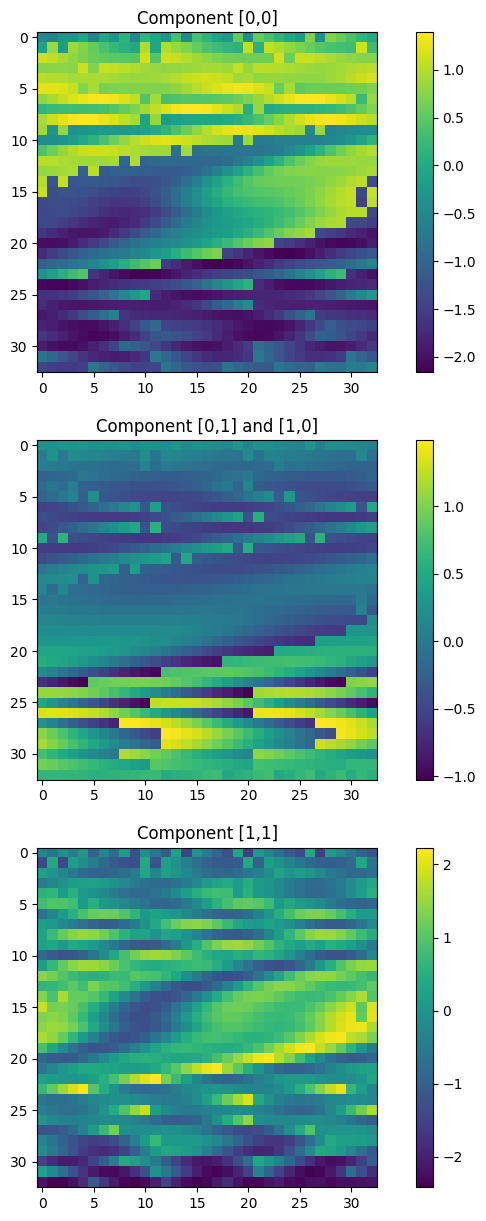

In [ ]:
# Extract components
# Determine reshaping dimensions
# Plot each component
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
img00 = axes[0].imshow(sigma.dat.data[:,0,0].reshape(33, 33))
axes[0].set_title('Component [0,0]')
fig.colorbar(img00, ax=axes[0])

img10 = axes[1].imshow(sigma.dat.data[:,1,0].reshape(33, 33))
axes[1].set_title('Component [0,1] and [1,0]')
fig.colorbar(img10, ax=axes[1])

img11 = axes[2].imshow(sigma.dat.data[:,1,1].reshape(33, 33))
axes[2].set_title('Component [1,1]')
fig.colorbar(img11, ax=axes[2])
plt.show()

## Generate dataset by constitutive equations

In [ ]:
from typing import Union, Callable
import os
import h5py

def generate_data(V, dataset_dir: str, E, nu, ntrain: int = 50, ntest: int = 10,
                  noise: Union[str, Callable] = "normal",
                  scale_noise: float = 1., seed: int = 1234):
    print("\n Generate random fields")
    print("\n Generate corresponding PDE solutions")
    
    # Generate random tensor fields
    stress_tensor_fields = []
    strain_tensor_fields = random_tensor_field(V, N=ntrain+ntest, tqdm=True, seed=20)
    for i in range(ntrain+ntest):
        V_tensor = fd.TensorFunctionSpace(mesh, "CG", 1)
        stress_field = forward(E, nu, strain_tensor_fields[i])
        stress_field = fd.project(stress_field, V_tensor)
        stress_tensor_fields.append(stress_field)
        
    print("\n Generated ", ntrain, " training samples and ",ntest, "test samples.")
    stress_train, stress_test = stress_tensor_fields[:ntrain], stress_tensor_fields[ntrain:]
    strain_train, strain_test = strain_tensor_fields[:ntrain], strain_tensor_fields[ntrain:]
    
     
    print("\nSave train/test data to", dataset_dir)
    with fd.CheckpointFile(os.path.join(dataset_dir, "train_data.h5"), "w") as afile:
        afile.h5pyfile["n"] = ntrain
        afile.save_mesh(mesh)
        for i in range(ntrain):
            afile.save_function(strain_train[i],idx=i, name="k")
            afile.save_function(stress_train[i],idx=i, name="u_obs")
        
    with fd.CheckpointFile(os.path.join(dataset_dir, "test_data.h5"), "w") as afile:
        afile.h5pyfile["n"] = ntest
        afile.save_mesh(mesh)
        for i in range(ntest):
            afile.save_function(strain_test[i],idx=i, name="k")
            afile.save_function(stress_test[i],idx=i, name="u_obs")
            
      

In [ ]:
ntrain = 100
ntest = 20

noise = "normal"
scale_noise = 1

nx = 10
ny = 10
Lx = 1
Ly = 1

E = 1
nu = 0.3    

degree = 1
data_dir = "data/datasets/linear_elasticity"
dataset_name = "linear_12"
seed = 12

mesh = fd.RectangleMesh(nx, ny, Lx, Ly, name="mesh")
V_tensor = fd.TensorFunctionSpace(mesh, "CG", degree)

generate_data(V_tensor, data_dir, E, nu, ntrain, ntest, noise, scale_noise, seed)


 Generate random fields

 Generate corresponding PDE solutions


  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [01:59<00:00,  1.01it/s]



 Generated  100  training samples and  20 test samples.

Save train/test data to data/datasets/linear_elasticity
